# Import libraries

In [1]:
import os
import joblib, json, re
import librosa as lb
import librosa.display as lbd
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

# Metadata

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\birdclef-2022\train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [3]:
species_counts = df['primary_label'].value_counts()

print(species_counts)

brnowl     500
skylar     500
norcar     500
mallar3    500
houspa     500
          ... 
puaioh       3
layalb       3
akikik       2
crehon       2
maupar       1
Name: primary_label, Length: 152, dtype: int64


In [4]:
species = df['primary_label'].unique()
print('Species:', species)

Species: ['afrsil1' 'akekee' 'akepa1' 'akiapo' 'akikik' 'amewig' 'aniani' 'apapan'
 'arcter' 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra'
 'blknod' 'bongul' 'brant' 'brnboo' 'brnnod' 'brnowl' 'brtcur' 'bubsan'
 'buffle' 'bulpet' 'burpar' 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas'
 'caster1' 'categr' 'chbsan' 'chemun' 'chukar' 'cintea' 'comgal1' 'commyn'
 'compea' 'comsan' 'comwax' 'coopet' 'crehon' 'dunlin' 'elepai' 'ercfra'
 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe' 'grbher3'
 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcoo' 'hawcre' 'hawgoo'
 'hawhaw' 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1'
 'jabwar' 'japqua' 'kalphe' 'kauama' 'laugul' 'layalb' 'lcspet' 'leasan'
 'leater1' 'lessca' 'lesyel' 'lobdow' 'lotjae' 'madpet' 'magpet1'
 'mallar3' 'masboo' 'mauala' 'maupar' 'merlin' 'mitpar' 'moudov' 'norcar'
 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama' 'omao' 'osprey'
 'pagplo' 'palila' 'parjae' 'pecsan' 'peflov

# Preprocessing

Selection 5 common species in Hawaii. Verifying their primary labels based on scientific names. Source: https://www.birdzilla.com/learn/birds-of-hawaii/.

In [6]:
scientific_names = [
    'Acridotheres tristis',
    'Geopelia striata',
    'Zosterops japonicus',
    'Streptopelia chinensis',
    'Haemorhous mexicanus'
]

# Filter the DataFrame for the rows containing our scientific names
matched_birds = df[df['scientific_name'].isin(scientific_names)]

# Since we are interested in primary_label for these scientific names,
# and assuming each scientific name corresponds to a unique primary label, drop duplicates
unique_matched_birds = matched_birds.drop_duplicates(subset=['scientific_name'])

# Select only the columns with the scientific names and their primary labels
result = unique_matched_birds[['scientific_name', 'primary_label']]

# Convert the result to a list of tuples [(scientific_name, primary_label), ...] for clarity
result_list = list(result.itertuples(index=False, name=None))

# Print the list of (scientific_name, primary_label) tuples
print(result_list)

[('Acridotheres tristis', 'commyn'), ('Haemorhous mexicanus', 'houfin'), ('Streptopelia chinensis', 'spodov'), ('Zosterops japonicus', 'warwhe1'), ('Geopelia striata', 'zebdov')]


In [7]:
selected_species = ['commyn', 'houfin', 'spodov', 'warwhe1', 'zebdov']

In [8]:
selected_df = df[df['primary_label'].isin(selected_species)]

In [9]:
selected_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
3342,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:23,https://www.xeno-canto.org/110873,commyn/XC110873.ogg
3343,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:24,https://www.xeno-canto.org/110874,commyn/XC110874.ogg
3344,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:32,https://www.xeno-canto.org/110875,commyn/XC110875.ogg
3345,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,4.0,13:33,https://www.xeno-canto.org/110876,commyn/XC110876.ogg
3346,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,4.0,13:35,https://www.xeno-canto.org/110877,commyn/XC110877.ogg


In [10]:
selected_df['primary_label'].value_counts()

houfin     322
commyn     208
spodov     107
zebdov      89
warwhe1     71
Name: primary_label, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_35032\4285690026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=species_count_sorted.index, x=species_count_sorted.values, palette='viridis')


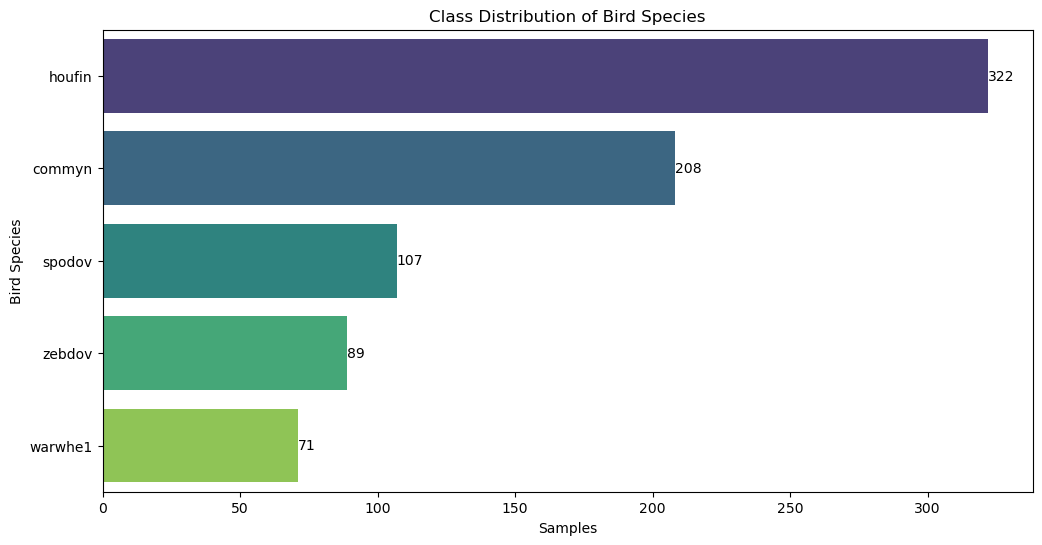

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of occurrences of each species
species_count = selected_df['primary_label'].value_counts()

# Sort species count for better visualization
species_count_sorted = species_count.sort_values(ascending=False)

# Create a bar plot for the species count with improved readability
plt.figure(figsize=(12, 6))
sns.barplot(y=species_count_sorted.index, x=species_count_sorted.values, palette='viridis')
plt.title('Class Distribution of Bird Species')
plt.xlabel('Samples')
plt.ylabel('Bird Species')

# Add data labels to each bar
for index, value in enumerate(species_count_sorted.values):
    plt.text(value, index, str(value), va='center')

plt.show()

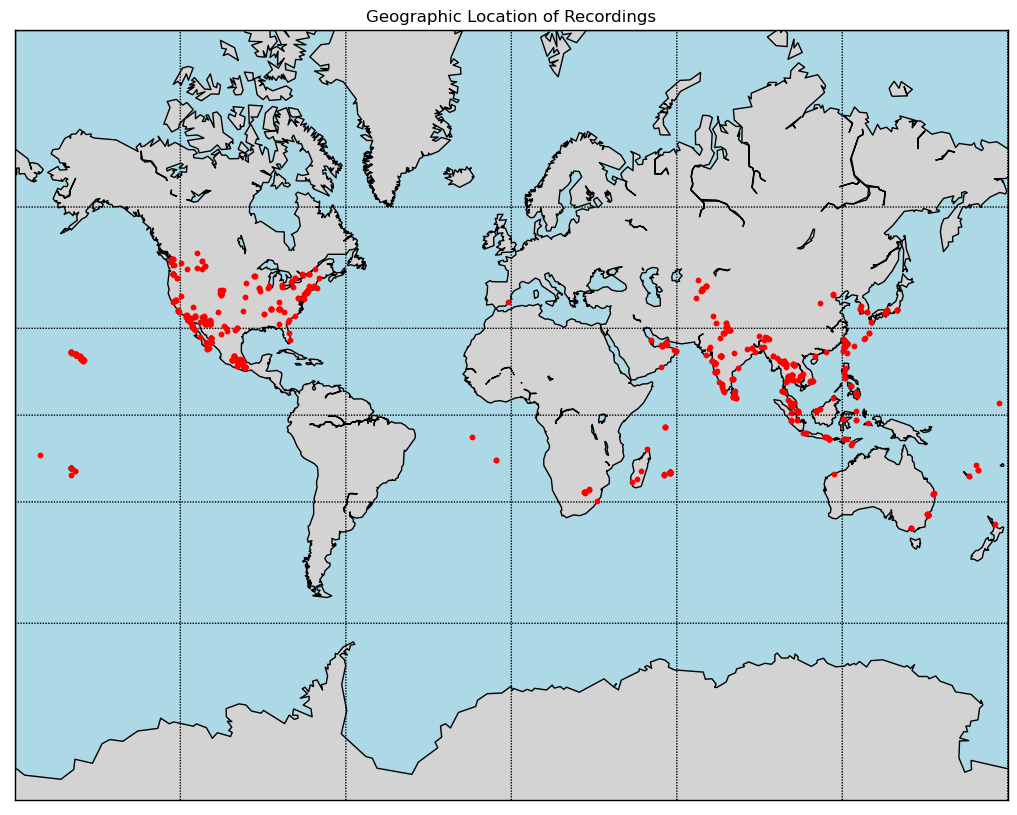

In [13]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(14, 10))
m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
m.drawcoastlines()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(np.arange(-90., 91., 30.))
m.drawmeridians(np.arange(-180., 181., 60.))
m.drawmapboundary(fill_color='lightblue')

# Make sure to use selected_df for both longitude and latitude
x, y = m(selected_df['longitude'].values, selected_df['latitude'].values)
m.scatter(x, y, marker='o', color='r', zorder=5, s=10)

plt.title("Geographic Location of Recordings")
plt.show()

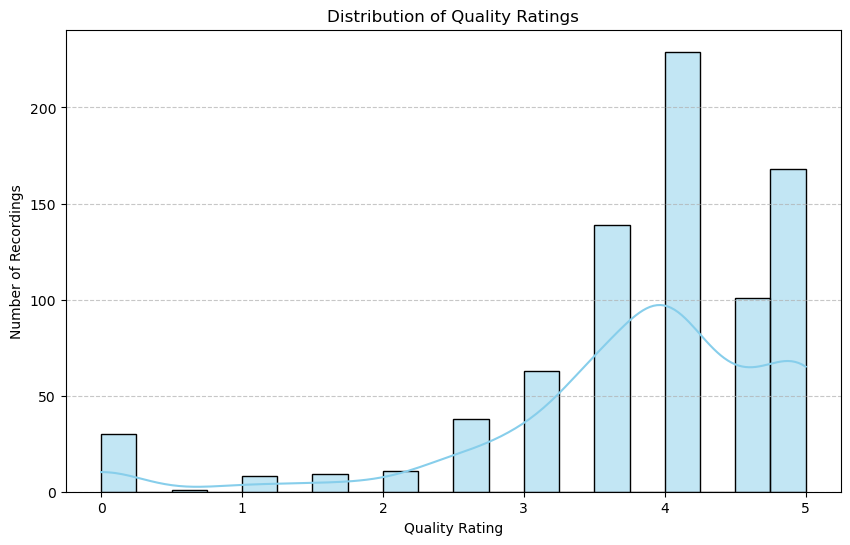

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting a histogram of the quality ratings with improved readability
plt.figure(figsize=(10, 6))
sns.histplot(data=selected_df, x='rating', bins=20, kde=True, color='skyblue', edgecolor='k')
plt.title('Distribution of Quality Ratings')
plt.xlabel('Quality Rating')
plt.ylabel('Number of Recordings')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid lines for better readability
plt.show()

# Exploring audio

In [15]:
from IPython.display import Audio

base_path = r'C:\Users\user\Desktop\birdclef-2022\train_audio'

sr = 32000

example = selected_df['filename'].iloc[0]

audio_file_path = os.path.join(base_path, example)

audio, _ = lb.load(audio_file_path, sr=sr)

Audio(audio, rate=sr)

### Adding info to selected_df

Adding valueble information to selected_df (path to audio file, frames, sr, duration)

In [16]:
def audio_info(filepath):
    data, sr = sf.read(filepath)
    frames = len(data)
    duration = float(frames) / sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [17]:
from joblib import Parallel, delayed

def add_info(df, base_path):
    """Enriches DataFrame with audio information."""
    # Generate full file paths
    df.loc[:, 'path'] = df['filename'].apply(lambda x: os.path.join(base_path, x))
    tasks = (delayed(audio_info)(filepath) for filepath in df['path'])
    audio_info_list = Parallel(n_jobs=2)(tqdm(tasks, total=len(df)))
    audio_info_df = pd.DataFrame(audio_info_list)
    enriched_df = pd.concat([df.reset_index(drop=True), audio_info_df.reset_index(drop=True)], axis=1)
    
    return enriched_df

In [18]:
enriched_df = add_info(selected_df, base_path)

C:\Users\user\AppData\Local\Temp\ipykernel_35032\3517966591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'path'] = df['filename'].apply(lambda x: os.path.join(base_path, x))


  0%|          | 0/797 [00:00<?, ?it/s]

In [19]:
enriched_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,path,frames,sr,duration
0,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:23,https://www.xeno-canto.org/110873,commyn/XC110873.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,243252,32000,7.601625
1,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:24,https://www.xeno-canto.org/110874,commyn/XC110874.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,187246,32000,5.851438
2,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,5.0,13:32,https://www.xeno-canto.org/110875,commyn/XC110875.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,150465,32000,4.702031
3,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,4.0,13:33,https://www.xeno-canto.org/110876,commyn/XC110876.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1462021,32000,45.688156
4,commyn,[],['call'],-18.8571,-159.7949,Acridotheres tristis,Common Myna,Matthias Feuersenger,Creative Commons Attribution-NonCommercial-Sha...,4.0,13:35,https://www.xeno-canto.org/110877,commyn/XC110877.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1366727,32000,42.710219


In [20]:
def verify_paths(df, base_path):
    mismatches = [
        f"Mismatch at index {index}: Expected {os.path.join(base_path, row['filename'])}, got {row['path']}"
        for index, row in df.iterrows()
        if os.path.join(base_path, row['filename']) != row['path']
    ]

    return "All paths are correct" if not mismatches else "There were mismatches in the paths:\n" + "\n".join(mismatches)
print(verify_paths(enriched_df, base_path))

All paths are correct


In [21]:
enriched_df["duration"].describe()

count     797.000000
mean       71.900242
std       247.360174
min         1.488969
25%        16.560000
50%        31.869375
75%        61.632000
max      4486.536000
Name: duration, dtype: float64

# Taking care of duplicates

Based on 'duration', 'latitude', 'type', 'primary_label', 'author'

In [22]:
duplicate_columns = ['duration', 'latitude', 'type', 'primary_label', 'author']

# Check for duplicates based on the specified columns
duplicates = enriched_df.duplicated(subset=duplicate_columns, keep=False)
if duplicates.any():
    print("There are duplicates based on the specified columns:")
    # Display the duplicate rows based on the specified columns
    print(enriched_df[duplicates])
else:
    print("No duplicates found based on the specified columns.")

There are duplicates based on the specified columns:
    primary_label secondary_labels      type  latitude  longitude  \
167        commyn               []  ['song']   18.5013    73.8049   
168        commyn               []  ['song']   18.5013    73.8049   
492        houfin               []  ['call']   19.2550   -99.0254   
496        houfin               []  ['call']   19.2550   -99.0254   
605        spodov               []  ['song']   -1.7124   103.4003   
606        spodov               []  ['song']   -1.7124   103.4003   

            scientific_name   common_name                     author  \
167    Acridotheres tristis   Common Myna             Rajgopal Patil   
168    Acridotheres tristis   Common Myna             Rajgopal Patil   
492    Haemorhous mexicanus   House Finch  Isain Contreras Rodríguez   
496    Haemorhous mexicanus   House Finch  Isain Contreras Rodríguez   
605  Streptopelia chinensis  Spotted Dove               Kevin Darras   
606  Streptopelia chinensis  Sp

In [23]:
# Remove duplicates based on the specified columns and keep the first occurrence
enriched_df = enriched_df.drop_duplicates(subset=duplicate_columns, keep='first')

# Splitting enriched_df to train and test

In [25]:
train_df, test_df = train_test_split(
    enriched_df,
    test_size=0.2,
    random_state=1234,
    stratify=enriched_df['primary_label']
)

In [26]:
display(len(train_df))
display(train_df.head())

635

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,path,frames,sr,duration
499,houfin,['gamqua'],"['adult', 'male', 'song']",31.9938,-112.8431,Haemorhous mexicanus,House Finch,Richard E. Webster,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:01,https://www.xeno-canto.org/621698,houfin/XC621698.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,6005238,32000,187.663688
318,houfin,['houspa'],['call'],19.3910,-99.2439,Haemorhous mexicanus,House Finch,Manuel Grosselet,Creative Commons Attribution-NonCommercial-Sha...,4.5,07:30,https://www.xeno-canto.org/314416,houfin/XC314416.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1898371,32000,59.324094
596,spodov,[],['song'],1.5249,110.3123,Streptopelia chinensis,Spotted Dove,Hobart WQH,Creative Commons Attribution-NonCommercial-Sha...,1.5,14:37,https://www.xeno-canto.org/443310,spodov/XC443310.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,355584,32000,11.112000
458,houfin,[],"['adult', 'male', 'song']",17.0166,-96.7262,Haemorhous mexicanus,House Finch,Omar Suárez García,Creative Commons Attribution-NonCommercial-Sha...,4.5,07:30,https://www.xeno-canto.org/566136,houfin/XC566136.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1878309,32000,58.697156
426,houfin,[],['call'],45.5582,-122.6928,Haemorhous mexicanus,House Finch,Thomas Magarian,Creative Commons Attribution-NonCommercial-Sha...,0.0,10:24,https://www.xeno-canto.org/531574,houfin/XC531574.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,863504,32000,26.984500


In [27]:
display(len(test_df))
display(test_df.head())

159

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,path,frames,sr,duration
76,commyn,['houspa'],['song'],-25.8401,28.2612,Acridotheres tristis,Common Myna,Faansie Peacock,Creative Commons Attribution-NonCommercial-Sha...,3.5,10:30,https://www.xeno-canto.org/323378,commyn/XC323378.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1583616,32000,49.488000
686,warwhe1,[],['call'],28.4468,129.5900,Zosterops japonicus,Warbling White-eye,Guy Kirwan,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:00,https://www.xeno-canto.org/409246,warwhe1/XC409246.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,1250528,32000,39.079000
30,commyn,[],['call'],43.9209,67.6331,Acridotheres tristis,Common Myna,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/183496,commyn/XC183496.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,852637,32000,26.644906
761,zebdov,[],"['call', 'display call or song', 'male', 'song']",1.5252,110.3124,Geopelia striata,Zebra Dove,Hobart WQH,Creative Commons Attribution-NonCommercial-Sha...,4.5,06:50,https://www.xeno-canto.org/439488,zebdov/XC439488.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,463104,32000,14.472000
250,houfin,"['calqua', 'houfin']",['call'],32.6809,-116.8189,Haemorhous mexicanus,House Finch,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...,3.5,10:54,https://www.xeno-canto.org/219338,houfin/XC219338.ogg,C:\Users\user\Desktop\birdclef-2022\train_audi...,2254848,32000,70.464000


In [28]:
train_df.to_csv(r'C:\Users\user\Desktop\birdclef-2022\train_df.csv', index=False, encoding='utf-8')

In [29]:
test_df.to_csv(r'C:\Users\user\Desktop\birdclef-2022\test_df.csv', index=False, encoding='utf-8')